# Лабораторная работа №3

## Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

### **Цель рабораторной работы:** изучение способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

#### Подготовка датафреймов
Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

Загрузим датасет, используется тот же самый, что и в первой ЛР.

In [2]:
data = pd.read_table('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt')
data.head()

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


Проверим наличие пропусков:

In [3]:
data.isnull().sum()

AGE    0
SEX    0
BMI    0
BP     0
S1     0
S2     0
S3     0
S4     0
S5     0
S6     0
Y      0
dtype: int64

Пропусков нет. Отлично, работаем дальше.

Выберем параметр 'Y' как целевой.
Отберем доп параметры:

In [4]:
nparr = data.to_numpy()

data_regr = pd.DataFrame(nparr.take([0, 2, 3, 6, 7, 8, 9, 10], 1), columns=data.columns.take([0, 2, 3, 6, 7, 8, 9, 10]))

data_regr.head()

,AGE,BMI,BP,S3,S4,S5,S6,Y
0,59.0,32.1,101.0,38.0,4.0,4.8598,87.0,151.0
1,48.0,21.6,87.0,70.0,3.0,3.8918,69.0,75.0
2,72.0,30.5,93.0,41.0,4.0,4.6728,85.0,141.0
3,24.0,25.3,84.0,40.0,5.0,4.8903,89.0,206.0
4,50.0,23.0,101.0,52.0,4.0,4.2905,80.0,135.0


Сделаем копии фреймов с масштабированием

In [5]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

# данные для регрессии
data_regr_scaled = data_regr.copy()

for col in data_regr.columns:
    data_regr_scaled[[col]] = sc.fit_transform(data_regr[[col]])

data_regr_scaled.describe()

,AGE,BMI,BP,S3,S4,S5,S6,Y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,0.491968,0.346107,0.459817,0.360889,0.291996,0.485560,0.503942,0.396054
std,0.218484,0.182567,0.194807,0.167977,0.182010,0.183366,0.174187,0.240165
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.320833,0.214876,0.309859,0.237013,0.141044,0.357542,0.382576,0.193146
50%,0.516667,0.318182,0.436620,0.337662,0.282087,0.478062,0.500000,0.359813
75%,0.666667,0.465909,0.605634,0.464286,0.423131,0.610446,0.606061,0.580997
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Метод KNN
Будем решать задачу регрессии для параметра 'Y'

<AxesSubplot:ylabel='Density'>

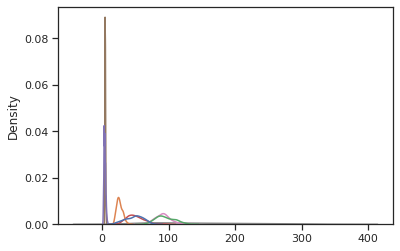

In [6]:
data_unscaled = data_regr
data_scaled = data_regr_scaled

sns.kdeplot(data = data_unscaled, legend = False)

<AxesSubplot:ylabel='Density'>

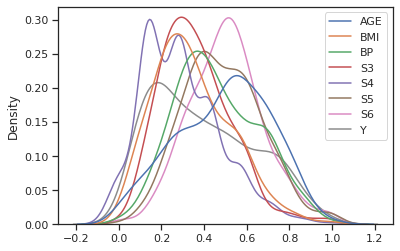

In [7]:
sns.kdeplot(data = data_scaled)

Разделим выборку на обучающую и тестовую

In [8]:
from sklearn.model_selection import train_test_split

test_size_global = 0.45
random_state_global = 1

y_col = 'Y'
x_cols = data_unscaled.columns.tolist()
x_cols.pop(x_cols.index(y_col))

data_unscaled_x_train, data_unscaled_x_test, data_unscaled_y_train, data_unscaled_y_test = train_test_split(
    data_unscaled[x_cols],
    data_unscaled[y_col],
    test_size=test_size_global,
    random_state=random_state_global
)

data_scaled_x_train, data_scaled_x_test, data_scaled_y_train, data_scaled_y_test = train_test_split(
    data_scaled[x_cols],
    data_scaled[y_col],
    test_size=test_size_global,
    random_state=random_state_global
)

Получим произвольную модель

In [9]:
from sklearn.neighbors import KNeighborsRegressor

K = 20

knn_unscaled = KNeighborsRegressor(n_neighbors=K)
knn_scaled = KNeighborsRegressor(n_neighbors=K)

knn_unscaled.fit(data_unscaled_x_train, data_unscaled_y_train)
knn_scaled.fit(data_scaled_x_train, data_scaled_y_train)

knn_unscaled_prediction = knn_unscaled.predict(data_unscaled_x_test)
knn_scaled_prediction = knn_scaled.predict(data_scaled_x_test)

Выведем метрики

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import ShuffleSplit, cross_val_score, cross_validate

def print_regression_metrics(type_of_data, y_test, y_predict):
    mean_abs_error = mean_absolute_error(y_test, y_predict)
    median_abs_error = median_absolute_error(y_test, y_predict)
    mean_sqr_error = mean_squared_error(y_test, y_predict)
    r2_sc = r2_score(y_test, y_predict)

    print(type_of_data + 
    f"1) Средняя абсолютная ошибка = {mean_abs_error}\n2) Медианная абсолютная ошибка = {median_abs_error}\n3) Среднекваратичная ошибка = {mean_sqr_error}\n4) Коэффициент детерминации = {r2_sc}\n"
    )

print_regression_metrics("Для немасштабированных данных\n", data_unscaled_y_test, knn_unscaled_prediction)
print_regression_metrics("Для масштабированных данных\n", data_scaled_y_test, knn_scaled_prediction)

Для немасштабированных данных
1) Средняя абсолютная ошибка = 50.394723618090445
2) Медианная абсолютная ошибка = 44.349999999999994
3) Среднекваратичная ошибка = 3834.372449748744
4) Коэффициент детерминации = 0.26977708377111287

Для масштабированных данных
1) Средняя абсолютная ошибка = 0.1432880915480831
2) Медианная абсолютная ошибка = 0.12647975077881624
3) Среднекваратичная ошибка = 0.03224689308675928
4) Коэффициент детерминации = 0.36721073190672426



Кросс-валидация

In [11]:
# Кросс-валидация по стратегии ShuffleSplit

sc_strategies = ['neg_root_mean_squared_error', 'r2']

data_unscaled_cv_scores = cross_validate(KNeighborsRegressor(
    n_neighbors = K),
    data_unscaled[x_cols],
    data_unscaled[y_col],
    scoring = sc_strategies,
    cv = ShuffleSplit(n_splits = 8,
    test_size = test_size_global, 
    random_state = random_state_global
    ))

data_scaled_cv_scores = cross_validate(KNeighborsRegressor(
    n_neighbors = K),
    data_scaled[x_cols],
    data_scaled[y_col],
    scoring = sc_strategies,
    cv = ShuffleSplit(n_splits = 8,
    test_size = test_size_global, 
    random_state = random_state_global
    ))

print('Кросс-валидация для немасштабированных данных')
for k, v in data_unscaled_cv_scores.items():
    print(f'{k}: {v}')

print('\nКросс-валидация для масштабированных данных')
for k, v in data_scaled_cv_scores.items():
    print(f'{k}: {v}')

Кросс-валидация для немасштабированных данных
fit_time: [0.00245357 0.00227809 0.00144815 0.00150037 0.00165081 0.00128722
 0.00117874 0.00116181]
score_time: [0.0043323  0.00376487 0.00247765 0.00265098 0.00244069 0.00230098
 0.00219083 0.00216556]
test_neg_root_mean_squared_error: [-61.92230979 -60.34481676 -62.84547912 -64.68622973 -61.37512857
 -68.08585374 -59.42667571 -65.23437365]
test_r2: [0.26977708 0.3162452  0.34499719 0.32255879 0.31763546 0.24678482
 0.31517729 0.2988317 ]

Кросс-валидация для масштабированных данных
fit_time: [0.00134516 0.00120449 0.00118876 0.00115013 0.00124431 0.00134873
 0.00136518 0.00133276]
score_time: [0.00240159 0.00228477 0.00229692 0.00226736 0.00247025 0.002455
 0.00244474 0.00250363]
test_neg_root_mean_squared_error: [-0.1795742  -0.17748036 -0.17241495 -0.17878493 -0.17348793 -0.18723816
 -0.16126366 -0.18153811]
test_r2: [0.36721073 0.39055981 0.49201019 0.46676358 0.43820197 0.41304598
 0.48036503 0.44048081]


Получение оптимальной модели  
Найдем оптимальное значение K, используя решетчатый поиск

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

tested_parameters = {"n_neighbors" : np.array(range(1, 100, 6))}

# Кросс-валидация по стратегии KFold
randomized_grid_search = RandomizedSearchCV(
    KNeighborsRegressor(), 
    tested_parameters, 
    n_iter = 15, 
    random_state = random_state_global, 
    cv = KFold(shuffle = True, random_state = random_state_global), 
    scoring = "neg_root_mean_squared_error"
)

randomized_grid_search.fit(data_unscaled[x_cols], data_unscaled[y_col])

randomized_best_param = randomized_grid_search.best_params_.get("n_neighbors")
print(randomized_best_param, randomized_grid_search.best_score_)

13 -62.01787504257286


Попробуем улучшить результат обычным решетчатым поиском

In [13]:
gs_params = {"n_neighbors" : np.array(range(1, 100))}
grid_search = GridSearchCV(
    KNeighborsRegressor(),
    gs_params,
    scoring = "neg_root_mean_squared_error",
    cv = KFold(shuffle = True, random_state = random_state_global)
)

grid_search.fit(data_unscaled[x_cols], data_unscaled[y_col])

non_randomized_best_param = grid_search.best_params_.get("n_neighbors")
print(non_randomized_best_param, grid_search.best_score_)

13 -62.01787504257286


Обучим оптимальную модель

In [14]:
cv_found_knn_unscaled = KNeighborsRegressor(n_neighbors=non_randomized_best_param)
cv_found_knn_unscaled.fit(data_unscaled_x_train, data_unscaled_y_train)
cv_found_knn_unscaled_prediction = cv_found_knn_unscaled.predict(data_unscaled_x_test)

print_regression_metrics("Немасштабированные данные, случайная модель\n", data_unscaled_y_test, knn_unscaled_prediction)
print_regression_metrics("Немасштабированные данные, оптимальная модель\n", data_unscaled_y_test, cv_found_knn_unscaled_prediction)

Немасштабированные данные, случайная модель
1) Средняя абсолютная ошибка = 50.394723618090445
2) Медианная абсолютная ошибка = 44.349999999999994
3) Среднекваратичная ошибка = 3834.372449748744
4) Коэффициент детерминации = 0.26977708377111287

Немасштабированные данные, оптимальная модель
1) Средняя абсолютная ошибка = 48.89331271743332
2) Медианная абсолютная ошибка = 39.46153846153847
3) Среднекваратичная ошибка = 3770.582884838394
4) Коэффициент детерминации = 0.281925252141366



Теперь аналогично для масштабированных данных

In [15]:
# Кросс-валидация по стратегии KFold
randomized_grid_search = RandomizedSearchCV(
    KNeighborsRegressor(), 
    tested_parameters, 
    n_iter = 15, 
    random_state = random_state_global, 
    cv = KFold(shuffle = True, random_state = random_state_global), 
    scoring = "neg_root_mean_squared_error"
)

randomized_grid_search.fit(data_scaled[x_cols], data_scaled[y_col])

randomized_best_param = randomized_grid_search.best_params_.get("n_neighbors")
print(randomized_best_param, randomized_grid_search.best_score_)


gs_params = {"n_neighbors" : np.array(range(1, 100))}
grid_search = GridSearchCV(
    KNeighborsRegressor(),
    gs_params,
    scoring = "neg_root_mean_squared_error",
    cv = KFold(shuffle = True, random_state = random_state_global)
)

grid_search.fit(data_scaled[x_cols], data_scaled[y_col])

non_randomized_best_param = grid_search.best_params_.get("n_neighbors")
print(non_randomized_best_param, grid_search.best_score_)


cv_found_knn_scaled = KNeighborsRegressor(n_neighbors=non_randomized_best_param)
cv_found_knn_scaled.fit(data_scaled_x_train, data_scaled_y_train)
cv_found_knn_scaled_prediction = cv_found_knn_scaled.predict(data_scaled_x_test)

print_regression_metrics("Масштабированные данные, случайная модель\n", data_scaled_y_test, knn_scaled_prediction)
print_regression_metrics("Масштабированные данные, оптимальная модель\n", data_scaled_y_test, cv_found_knn_scaled_prediction)

25 -0.17680075599261105
28 -0.17631073656337662
Масштабированные данные, случайная модель
1) Средняя абсолютная ошибка = 0.1432880915480831
2) Медианная абсолютная ошибка = 0.12647975077881624
3) Среднекваратичная ошибка = 0.03224689308675928
4) Коэффициент детерминации = 0.36721073190672426

Масштабированные данные, оптимальная модель
1) Средняя абсолютная ошибка = 0.14431469765382318
2) Медианная абсолютная ошибка = 0.12494437027147309
3) Среднекваратичная ошибка = 0.03165749821490169
4) Коэффициент детерминации = 0.3787765825633208



Как мы видим, для масштабированных данных подбор гиперпараметра K не сильно изменил качество модели, а для немасштабированных улучшил.